<a href="https://colab.research.google.com/github/wpyx/test1/blob/main/palm_oil_seasonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install statsmodels==0.11.0
!pip install fredapi
!pip install pmdarima
!pip install monthly-returns-heatmap

     |████████████████████████████████| 8.7 MB 5.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 1.4 MB 7.9 MB/s 
  Created wheel for monthly-returns-heatmap: filename=monthly_returns_heatmap-0.0.11-py3-none-any.whl size=8110 sha256=a2f6a29394a249ce585345d18056266f6e808d205e3bfcdc649a3e62126110b3
  Stored in directory: /root/.cache/pip/wheels/de/fe/19/eaf9f233e8b0bc285d13bba68986333ae841e657448771d455
Successfully built monthly-returns-heatmap


In [3]:
# import required packages 
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Data collection**

In [4]:
fred = Fred(api_key = '6f7ee273204e122975e49e48a0b43f22')
data = fred.get_series('PPOILUSDM') # Global palm oil price

In [5]:
# this climate data is taken from timeseries available in https://climateknowledgeportal.worldbank.org/download-data
# this data of Precipitation and MeanTemp is specific to country Malaysia
climatedata = pd.read_csv('https://raw.githubusercontent.com/wpyx/test1/main/MalaysiaClimateData.csv')
climatedata['Date'] = pd.to_datetime(climatedata['Date'], format = '%Y-%m-%d')
climatedata = climatedata.set_index('Date')
climatedata.head()

,Precipitation,MeanTemp
Date,,
1990-01-01,207.07,24.93
1990-02-01,136.06,25.47
1990-03-01,155.24,25.72
1990-04-01,267.98,26.29
1990-05-01,302.65,26.16


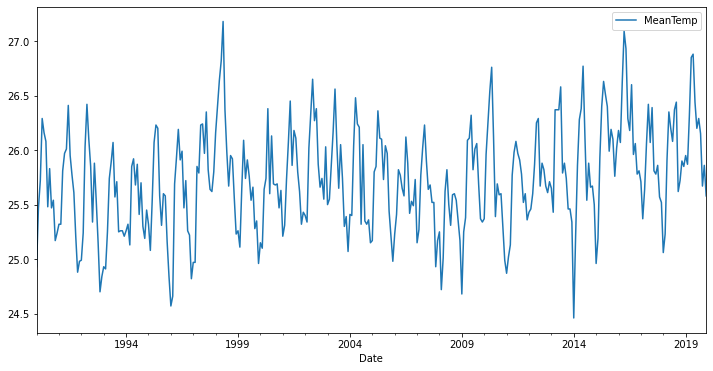

In [6]:
climatedata[['MeanTemp']].plot(figsize = (12, 6))

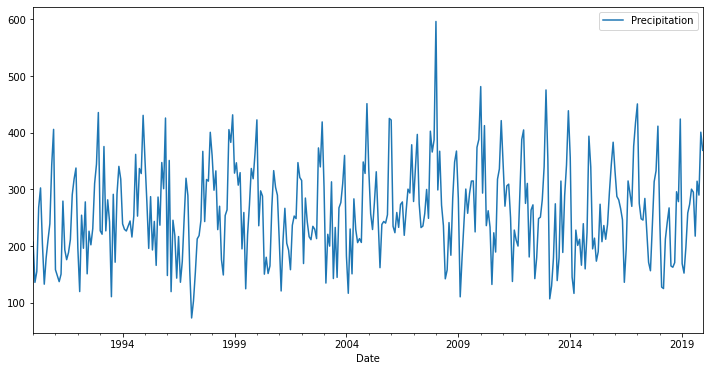

In [7]:
climatedata[['Precipitation']].plot(figsize = (12, 6))

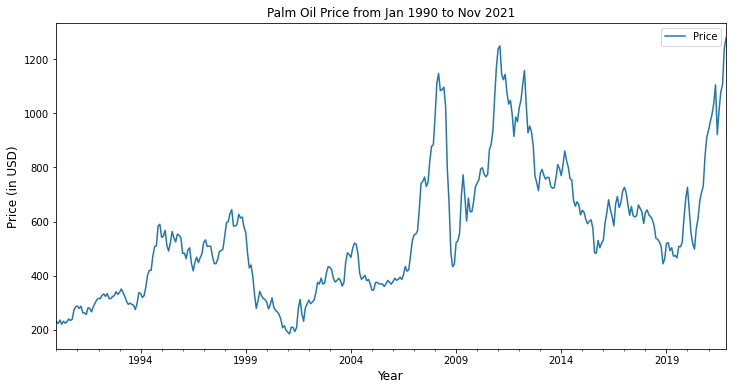

In [8]:
df = pd.DataFrame(data,columns=['Price'])
# drop na values and rename column 
df = df.dropna(axis = 0)
df.columns = ['Price']
df.plot(figsize = (12, 6))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Price (in USD)", fontsize=12)
plt.title('Palm Oil Price from Jan 1990 to Nov 2021')
plt.show()

## Dickey-Fuller Test

In [9]:
# apply a dickey-fuller test to check for stationarity.
# Time series are stationary if they do not have trend or seasonal effects.
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.580225
p-value: 0.493519
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Looking at the above, we obtain a negative test statistic.

Comparing the test statistic to the critical values, it looks like it is larger than the critical values. We would have to fail to reject the null hypothesis that the time series is non-stationary and does have time-dependent structure.

## Decompose Time Series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


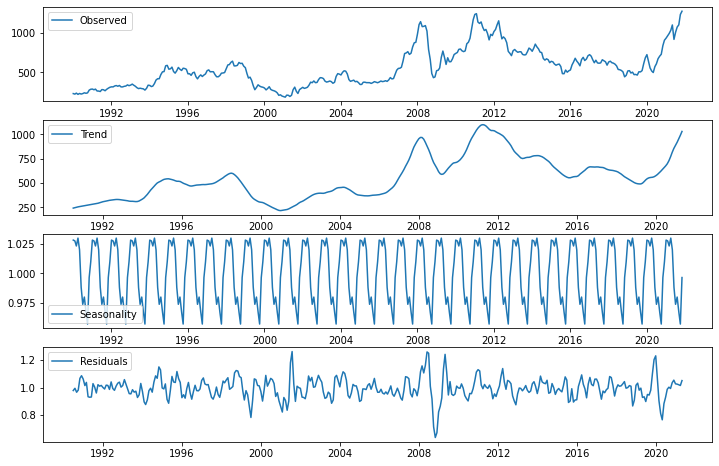

In [10]:
# decompose time series into components 

from statsmodels.tsa.seasonal import seasonal_decompose

analysis = df['Price'].copy()

decompose_result_mult = seasonal_decompose(analysis, model="multiplicative", freq = 12)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

Assuming a multiplicative model of Y[t] = T[t] * S[t] * e[t], we decomposed the time series into three individual components: trend, seasonal and residual. 

We observed a strong seasonal pattern. In terms of trend, we saw that palm oil prices have exhibited an upward trend since 1990. Prices plateaued around 2012 and started to decline before rebounding sharply again in 2019. Residual effects were strong in 2009 and also 2020. 

## Plot monthly heatmap to detect seasonality

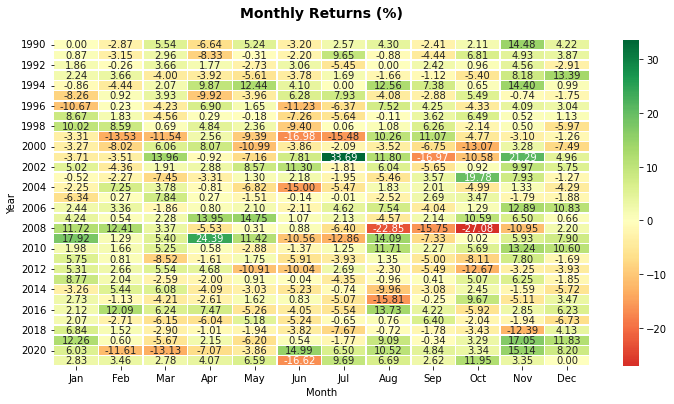

In [11]:
import monthly_returns_heatmap as mrh
returns = df.pct_change()
plt.figure(figsize=(12,8))
mrh.plot(returns)

In [12]:
heatmap = mrh.get(returns)
avg_monthly_rets = heatmap.mean() 
avg_monthly_rets.sort_values()

Month
Jun   -0.026563
Sep   -0.005344
Jul   -0.003363
May   -0.002040
Oct   -0.001394
Mar    0.003916
Feb    0.003992
Apr    0.009906
Aug    0.017334
Dec    0.017711
Jan    0.024766
Nov    0.045508
dtype: float64

Looking at the table above, it seems like average palm oil returns are strongest in November, January and December. 

The weakest returns are seen in June, September and July. 

As an observation, we could see that better returns are generally clustered around year-end (November and December) whereas mid-year returns are generally worse (June and July). 

As a result, an investor who buys and holds over November and December and sells in June and July can expect to generate a better performance than a buy-and-hold approach over the whole year. 

##FFT Analysis on the seasonality:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'amplitude')

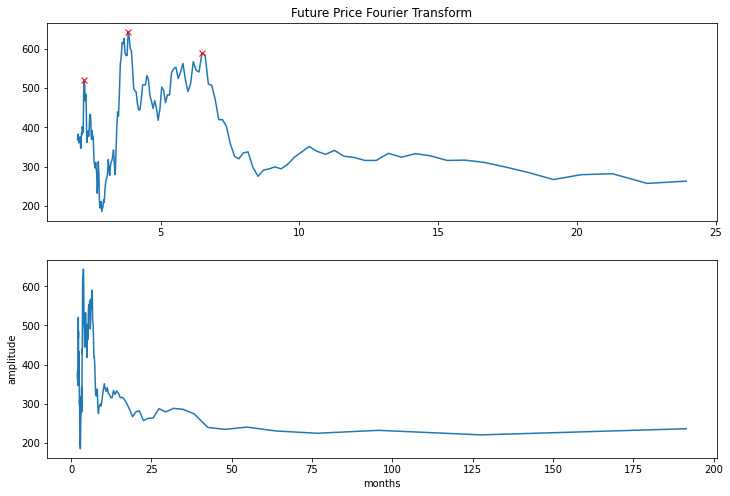

In [13]:
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks

yf = fftshift(fft(df))
# xf = fftfreq(len(df),1)
xf = fftshift(fftfreq(len(df)))

# plt.plot(xf,yf)

df_tf = pd.DataFrame(np.array([xf,np.array(abs(yf)).flatten()]).T,columns=['xf','yf'])
df_tf['xfinv'] = 1/xf
df_pl = df_tf.query('xfinv>0 & xfinv<30')

peaks, _ = find_peaks(df_pl['yf'], prominence=100)

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.title('Future Price Fourier Transform')
plt.plot(df_tf.query('xfinv>0 & xfinv<25')['xfinv'],df_tf.query('xfinv>0 & xfinv<25')['yf'])
plt.plot(df_pl['xfinv'].values[peaks], df_pl['yf'].values[peaks], "xr")
plt.subplot(212)
plt.plot(df_tf.query('xfinv>0 & xfinv<250')['xfinv'],df_tf.query('xfinv>0 & xfinv<250')['yf'])
plt.xlabel('months')
plt.ylabel('amplitude')


In [14]:
#df_tf = pd.DataFrame(np.array([xf,np.array(abs(yf)).flatten()]).T,columns=['xf','yf'])
##df_tf['xfinv'] = 1/xf
#df_pl = df_tf.query('xfinv>0 & xfinv<30')

#peaks, _ = find_peaks(df_pl['yf'], prominence=100)

#plt.plot(df_pl['xfinv'],df_pl['yf'])
#plt.plot(df_pl['xfinv'].values[peaks], df_pl['yf'].values[peaks], "xr")
#plt.xlabel('months')
#plt.ylabel('amplitude')


df_pl.iloc[peaks][['xfinv','yf']]

,xfinv,yf
250,6.491525,590.024906
291,3.830000,643.723706
361,2.252941,520.572082


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Text(0, 0.5, 'amplitude')

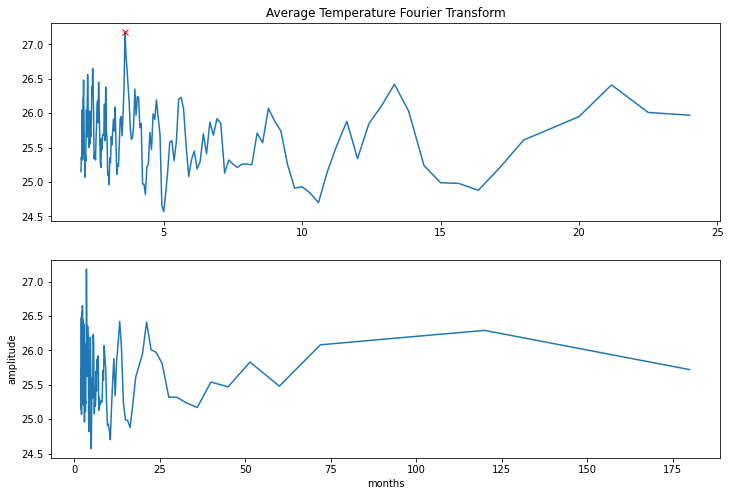

In [15]:
yf = fftshift(fft(climatedata[['MeanTemp']]))
xf = fftshift(fftfreq(len(climatedata)))

# plt.plot(xf,yf)

df_tf = pd.DataFrame(np.array([xf,np.array(abs(yf)).flatten()]).T,columns=['xf','yf'])
df_tf['xfinv'] = 1/xf
df_pl = df_tf.query('xfinv>0 & xfinv<25')

peaks, _ = find_peaks(df_pl['yf'], prominence=2)

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.title('Average Temperature Fourier Transform')
plt.plot(df_tf.query('xfinv>0 & xfinv<25')['xfinv'],df_tf.query('xfinv>0 & xfinv<25')['yf'])
plt.plot(df_pl['xfinv'].values[peaks], df_pl['yf'].values[peaks], "xr")
plt.subplot(212)
plt.plot(df_tf.query('xfinv>0 & xfinv<250')['xfinv'],df_tf.query('xfinv>0 & xfinv<250')['yf'])
plt.xlabel('months')
plt.ylabel('amplitude')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Text(0, 0.5, 'amplitude')

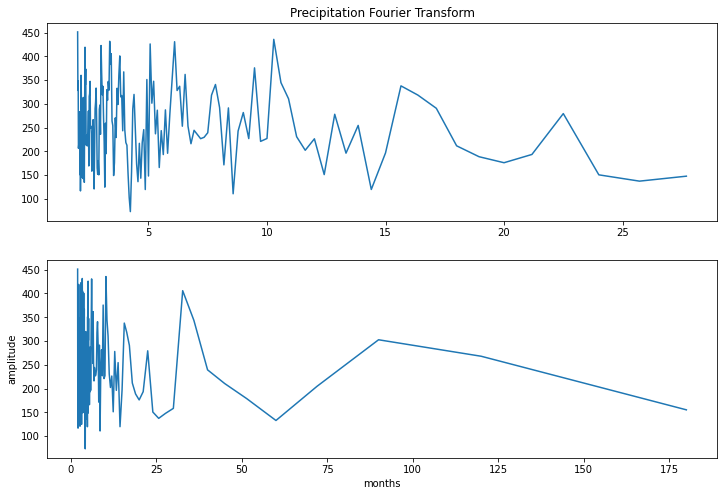

In [16]:
yf = fftshift(fft(climatedata[['Precipitation']]))
xf = fftshift(fftfreq(len(climatedata)))

# plt.plot(xf,yf)

df_tf = pd.DataFrame(np.array([xf,np.array(abs(yf)).flatten()]).T,columns=['xf','yf'])
df_tf['xfinv'] = 1/xf
df_pl = df_tf.query('xfinv>0 & xfinv<30')

#peaks, _ = find_peaks(df_pl['yf'], prominence=2)

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.title('Precipitation Fourier Transform')
plt.plot(df_tf.query('xfinv>0 & xfinv<30')['xfinv'],df_tf.query('xfinv>0 & xfinv<30')['yf'])
#plt.plot(df_pl['xfinv'].values[peaks], df_pl['yf'].values[peaks], "xr")
plt.subplot(212)
plt.plot(df_tf.query('xfinv>0 & xfinv<250')['xfinv'],df_tf.query('xfinv>0 & xfinv<250')['yf'])
plt.xlabel('months')
plt.ylabel('amplitude')


Graph: the top one is short term (up to 25-30 mths), to periodicity of up to 2 years, while the bottom one is longer term frequency (up to 10+ years)

Few observations: 
For future prices, the Fourier transform peaks correspond to dominant frequencies at which the time series cycle occurs. Interestingly in this case, there are no strong seasonality detected that correspond to yearly cycles (12 months). Instead, we observed that there are peaks around 3.8 and 6.5 months.

In the Temperature and Precipitation Fourier transform, we see peak somewhat around 10-14 months, indicating annual seasonality. The amplitude is not really dominating, which is quite consistent with the fact that South East Asian climate does not experience any major temperature swing as the season change.


From the longer term graph, we can see additional bump in natural phenomenon such as temperature and precipitation that is not really observed in the Fourier transform of the palm oil future prices. There are two: one around ballpark of 2-3 years, and the other one around ballpark of 8-10 years. These features likely to coincide with the larger climate cycle such as El Nino and La Nina. 

## Seasonal ARIMA 




In [18]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df.Price, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3923.552, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3968.390, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3926.208, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3921.616, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3967.918, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3923.555, Time=1.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3925.202, Time=1.86 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3920.537, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3922.449, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3922.453, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3924.998, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3924.026, Time=0.88 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.613 seconds
                               SARIMAX Results                                
Dep. Vari

In [20]:
# YK: Same as the above but with seasonality = True... looks like the same result though
model = pm.auto_arima(df.Price, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   #  seasonal                      
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3923.552, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3968.390, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3926.208, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3921.616, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3967.918, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3923.555, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3925.202, Time=0.96 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3920.537, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3922.449, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3922.453, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3924.998, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3924.026, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.014 seconds
                               SARIMAX Results                                
Dep. Vari

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df.Price, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  383
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1958.268
Date:                Sun, 24 Apr 2022   AIC                           3920.537
Time:                        07:27:04   BIC                           3928.427
Sample:                    01-01-1990   HQIC                          3923.667
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3654      0.033     11.091      0.000       0.301       0.430
sigma2      1659.7159     66.789     24.850      0.000    1528.812    1790.619
Ljung-Box (Q):                       69.50   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


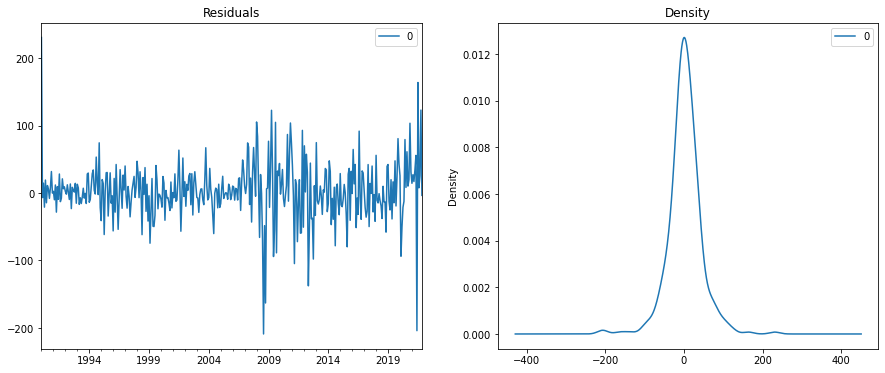

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(15)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
#plt.show()

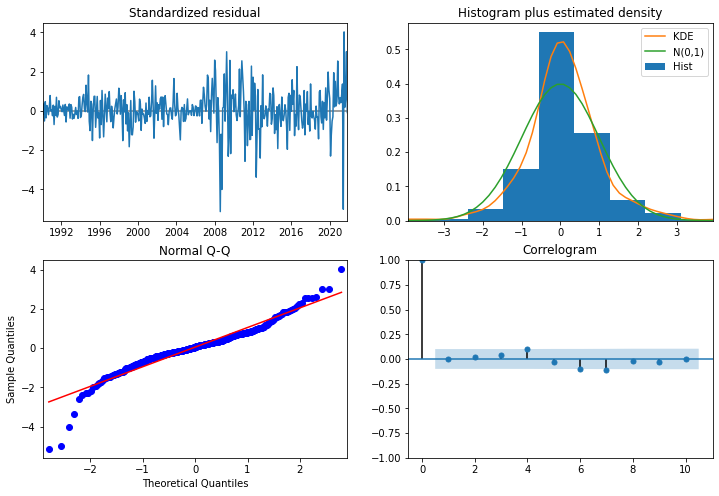

In [ ]:
model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

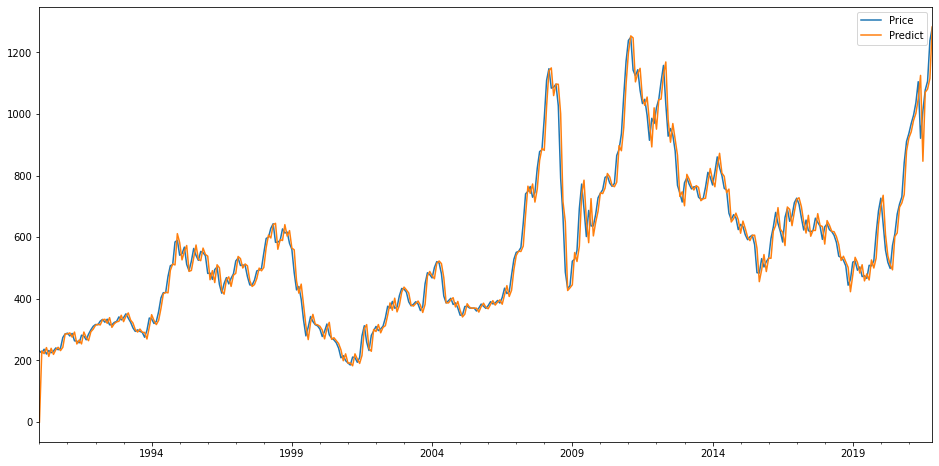

In [ ]:
df2 = df.copy()
df2['Predict'] = model_fit.predict()
df2.plot(figsize=(16,8))
#plt.show()

## Regression with Weather Data

In [ ]:
# import weather data to be used as input 
fulldf = climatedata.copy()
fulldf['Price'] = df['Price']
fulldf['Return'] = df['Price'].pct_change()
fulldf.head()

,Precipitation,MeanTemp,Price,Return
Date,,,,
1990-01-01,207.07,24.93,230.555951,NaN
1990-02-01,136.06,25.47,223.945027,-0.028674
1990-03-01,155.24,25.72,236.340509,0.055351
1990-04-01,267.98,26.29,220.639566,-0.066434
1990-05-01,302.65,26.16,232.208681,0.052434


In [ ]:
# Get average precipitation per month - looks like rainfall is highest in Nov and Dec and lowest in June and July
prec = mrh.get(fulldf[['Precipitation']])
avg_rainfall = prec.mean() 
avg_rainfall.sort_values(ascending = False)

Month
Dec    390.471667
Nov    337.085667
Oct    301.070333
Jan    297.498333
May    251.987000
Apr    239.448333
Aug    236.385667
Mar    234.040333
Sep    232.407333
Feb    213.514667
Jun    205.553667
Jul    196.054667
dtype: float64

In [ ]:
# Convert month to get dummy variables
fulldf['month'] = fulldf.index.strftime("%b")
dummies = pd.get_dummies(fulldf['month'])
dummies.head()

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,
1990-01-01,0,0,0,0,1,0,0,0,0,0,0,0
1990-02-01,0,0,0,1,0,0,0,0,0,0,0,0
1990-03-01,0,0,0,0,0,0,0,1,0,0,0,0
1990-04-01,1,0,0,0,0,0,0,0,0,0,0,0
1990-05-01,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Combine df to get dummy variable columns 
show_dummy = fulldf.copy()
show_dummy = show_dummy.drop(['month'], axis = 1)
show_dummy = show_dummy.join(dummies)
show_dummy = show_dummy.dropna()

In [ ]:
# Run regression
import statsmodels.formula.api as smf
lin_reg = smf.ols(formula='Return~Precipitation + MeanTemp', data=show_dummy).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.962
Date:                Sun, 24 Apr 2022   Prob (F-statistic):             0.0199
Time:                        07:27:06   Log-Likelihood:                 444.63
No. Observations:                 359   AIC:                            -883.3
Df Residuals:                     356   BIC:                            -871.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0968      0.214      0.452      0.652      -0.325       0.518
Precipitation     0.0001   4.63e-05      2.535      0.012    2.63e-05       0.000
MeanTemp         -0.0047      0.008     -0.578      0.564      -0.021       0.011
==============================================================================
Omnibus:                       26.571   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.734
Skew:                           0.228   Prob(JB):                     1.08e-18
Kurtosis:                       5.307   Cond. No.                     1.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the above, we could see that the P value for Precipitation is less than 5%, indicating that it is likely significant. On the other hand, the P-value for MeanTemp is high at 0.564, and given that meanTemp is more or less stable throughout the year, this is unlikely to have any statistical significance on final returns. 

In [ ]:
# Regress again but now with monthly dummy varaibles included
lin_reg_dummy = smf.ols(formula='Return~ Precipitation + MeanTemp + Jan + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec', data=show_dummy).fit()
lin_reg_dummy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.861
Date:                Sun, 24 Apr 2022   Prob (F-statistic):             0.0335
Time:                        07:27:06   Log-Likelihood:                 452.84
No. Observations:                 359   AIC:                            -877.7
Df Residuals:                     345   BIC:                            -823.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2363      0.268     -0.881      0.379      -0.764       0.291
Precipitation  6.189e-05    6.1e-05      1.014      0.311   -5.82e-05       0.000
MeanTemp          0.0095      0.011      0.842      0.400      -0.013       0.032
Jan               0.0010      0.021      0.049      0.961      -0.041       0.043
Feb              -0.0117      0.022     -0.531      0.596      -0.055       0.032
Mar              -0.0166      0.026     -0.633      0.527      -0.068       0.035
Apr              -0.0166      0.030     -0.552      0.582      -0.076       0.043
May              -0.0331      0.031     -1.061      0.289      -0.094       0.028
Jun              -0.0532      0.030     -1.797      0.073      -0.112       0.005
Jul              -0.0316      0.027     -1.157      0.248      -0.085       0.022
Aug              -0.0123      0.027     -0.455      0.649      -0.065       0.041
Sep              -0.0316      0.025     -1.239      0.216      -0.082       0.019
Oct              -0.0327      0.024     -1.368      0.172      -0.080       0.014
Nov               0.0156      0.023      0.685      0.494      -0.029       0.060
Dec              -0.0136      0.023     -0.584      0.559      -0.059       0.032
==============================================================================
Omnibus:                       27.980   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.522
Skew:                           0.244   Prob(JB):                     3.64e-20
Kurtosis:                       5.397   Cond. No.                     2.27e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.28e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We could see that by introducing monthly dummy variables, the R^2 value improved from 0.022 to 0.066. This indicates that there are potentially stronger predictive factor in certain months. For instance, we could see that precipitation is highest in Nov and December, which coincides with high monthly returns. 

In [ ]:
# Check correlation between variables
show_dummy.corr()

,Precipitation,MeanTemp,Price,Return,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Precipitation,1.000000,-0.240953,0.132701,0.144415,-0.080278,-0.091456,0.470909,-0.174927,0.140351,-0.238651,-0.203983,-0.100015,-0.034516,0.276067,0.144623,-0.105975
MeanTemp,-0.240953,1.000000,0.022012,-0.064189,0.285591,0.085948,-0.241544,-0.248227,-0.298904,0.092632,0.245490,0.045200,0.359972,-0.213516,-0.110029,-0.007190
Price,0.132701,0.022012,1.000000,0.057339,0.024460,-0.017983,0.005260,0.016678,0.019444,-0.017980,-0.004224,0.017689,0.021404,-0.006201,-0.032640,-0.025608
Return,0.144415,-0.064189,0.057339,1.000000,0.025670,0.030731,0.045225,0.006105,0.078323,-0.061864,-0.141951,0.008897,-0.036741,0.156892,-0.051638,-0.058450
Apr,-0.080278,0.285591,0.024460,0.025670,1.000000,-0.091185,-0.091185,-0.091185,-0.089517,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185
Aug,-0.091456,0.085948,-0.017983,0.030731,-0.091185,1.000000,-0.091185,-0.091185,-0.089517,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185
Dec,0.470909,-0.241544,0.005260,0.045225,-0.091185,-0.091185,1.000000,-0.091185,-0.089517,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185
Feb,-0.174927,-0.248227,0.016678,0.006105,-0.091185,-0.091185,-0.091185,1.000000,-0.089517,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185
Jan,0.140351,-0.298904,0.019444,0.078323,-0.089517,-0.089517,-0.089517,-0.089517,1.000000,-0.089517,-0.089517,-0.089517,-0.089517,-0.089517,-0.089517,-0.089517
Jul,-0.238651,0.092632,-0.017980,-0.061864,-0.091185,-0.091185,-0.091185,-0.091185,-0.089517,1.000000,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185,-0.091185


Once again we see that the correlation between precipitation and months is the highest in Nov and Dec. On the other hand, this correlation is the lowest in Jun and July. Similarly, correlation between return and months also exhibited a similar trend.

One possible explanation for this is that high precipitation is not conducive for palm oil production and as a result lower stock level may lead to higher prices. 

## Adding Indonesia weather data into regression model


In [ ]:
# Read CSV for Indonesia weather data - similar to Malaysia weather data
climatedataID = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT7GHzQkQ2eLDYVMHzNLD5QWuiQntuA5VMCLhXX7_RxO_d76fPHog48unrbPNY9ABKhN5jnzHu_IBf_/pub?gid=0&single=true&output=csv')
climatedataID['Date'] = pd.to_datetime(climatedataID['Date'], format = '%Y-%m-%d')
climatedataID = climatedataID.set_index('Date')
climatedataID.head()

,Precipitation_ID,MeanTemp_ID
Date,,
1990-01-01,282.62,25.61
1990-02-01,225.38,26.00
1990-03-01,294.66,26.23
1990-04-01,296.41,26.56
1990-05-01,217.99,26.33


In [ ]:
show_dummy_with_ID = show_dummy.join(climatedataID)
show_dummy_with_ID.head()

,Precipitation,MeanTemp,Price,Return,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Precipitation_ID,MeanTemp_ID
Date,,,,,,,,,,,,,,,,,,
1990-02-01,136.06,25.47,223.945027,-0.028674,0,0,0,1,0,0,0,0,0,0,0,0,225.38,26.00
1990-03-01,155.24,25.72,236.340509,0.055351,0,0,0,0,0,0,0,1,0,0,0,0,294.66,26.23
1990-04-01,267.98,26.29,220.639566,-0.066434,1,0,0,0,0,0,0,0,0,0,0,0,296.41,26.56
1990-05-01,302.65,26.16,232.208681,0.052434,0,0,0,0,0,0,0,0,1,0,0,0,217.99,26.33
1990-06-01,204.69,26.08,224.771393,-0.032028,0,0,0,0,0,0,1,0,0,0,0,0,135.00,25.96


In [ ]:
# Regress again with monthly dummy variables and Indonesia weather data
lin_reg_dummy_with_ID = smf.ols(formula='Return~ Precipitation + MeanTemp +  Precipitation_ID + MeanTemp_ID + Jan + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec', data=show_dummy_with_ID).fit()
lin_reg_dummy_with_ID.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.977
Date:                Sun, 24 Apr 2022   Prob (F-statistic):             0.0162
Time:                        07:27:07   Log-Likelihood:                 455.56
No. Observations:                 359   AIC:                            -879.1
Df Residuals:                     343   BIC:                            -817.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.2441      0.518     -2.402      0.017      -2.263      -0.225
Precipitation     7.374e-05   7.41e-05      0.996      0.320   -7.19e-05       0.000
MeanTemp            -0.0442      0.026     -1.674      0.095      -0.096       0.008
Precipitation_ID -3.797e-05      0.000     -0.263      0.793      -0.000       0.000
MeanTemp_ID          0.0949      0.042      2.268      0.024       0.013       0.177
Jan                 -0.0877      0.045     -1.941      0.053      -0.177       0.001
Feb                 -0.1037      0.047     -2.216      0.027      -0.196      -0.012
Mar                 -0.1018      0.048     -2.140      0.033      -0.195      -0.008
Apr                 -0.1033      0.050     -2.070      0.039      -0.202      -0.005
May                 -0.1122      0.047     -2.403      0.017      -0.204      -0.020
Jun                 -0.1099      0.039     -2.854      0.005      -0.186      -0.034
Jul                 -0.0748      0.033     -2.237      0.026      -0.141      -0.009
Aug                 -0.0660      0.036     -1.822      0.069      -0.137       0.005
Sep                 -0.1084      0.042     -2.567      0.011      -0.191      -0.025
Oct                 -0.1462      0.055     -2.656      0.008      -0.254      -0.038
Nov                 -0.1058      0.058     -1.816      0.070      -0.220       0.009
Dec                 -0.1243      0.055     -2.279      0.023      -0.232      -0.017
==============================================================================
Omnibus:                       26.293   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.383
Skew:                           0.188   Prob(JB):                     1.75e-19
Kurtosis:                       5.373   Cond. No.                     2.79e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.19e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

From the table above, it does seem like including Indonesia weather data helped to improve the R-square further to 0.080. 

Another observation is that the P-value for Jun and Dec are among the lowest, suggesting that these months could be significant. This is in line with our earlier observation that monthly returns are more extreme in these months (highest in Nov/Dec and lowest in Jun). This may have to do with precipitation, which exhibits a similar seasonal pattern, although the P-value in the final regression does not seem to be statistically significant. 